In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import numpy as np
from datetime import datetime, timedelta
import math
import json
from collections import Counter
from adjustText import adjust_text

In [4]:
index_list_names = [
    "loadtest-webrtc-2024-kurento-2p",
    "loadtest-webrtc-2024-kurento-8p",
    "loadtest-webrtc-2024-kurento-3p-10s",
    "loadtest-webrtc-2024-kurento-3p-40s",
    "loadtest-webrtc-2024-pion-2p",
    "loadtest-webrtc-2024-pion-8p",
    "loadtest-webrtc-2024-pion-3p-10s",
    "loadtest-webrtc-2024-pion-3p-40s",
]

In [9]:
full_user_data = {}

for index_list_name in index_list_names:
    full_user_data[index_list_name] = []
    for entry in os.scandir(f'stats/{index_list_name}'):
        if entry.is_dir():
            for sub_entry in os.scandir(entry.path):
                if sub_entry.is_dir():
                    with open(os.path.join(sub_entry.path, 'stats.json'), 'r') as f:
                        stats = json.load(f)
                    with open(os.path.join(sub_entry.path, 'events.json'), 'r') as f:
                        events = json.load(f)
                    with open(os.path.join(sub_entry.path, 'connections.json'), 'r') as f:
                        connections = json.load(f)
                    full_user_data[index_list_name].append({
                        'user': sub_entry.name,
                        'session': entry.name,
                        'stats': stats,
                        'events': events,
                        'connections': connections
                    })

seconds_per_fragment = 17

In [11]:
events_dfs = {}
for index_list_name in index_list_names:
    data = []
    user_data = full_user_data[index_list_name]
    for user in user_data:
        for event in user['events']:
            data.append({
                'user': user['user'],
                'session': user['session'],
                'event': event['event'],
                'connection': event['connection'] if 'connection' in event else None,
                'timestamp': event['timestamp'],
                'publishers': 0,
                'subscribers': 0,
                'streams_in': 0,
                'streams_out': 0
            })
    events_df = pd.DataFrame(data)
    # convert timestamp to datetime
    events_df['timestamp'] = pd.to_datetime(events_df['timestamp'])
    # sort by timestamp
    events_df = events_df.sort_values(by='timestamp')
    events_dfs[index_list_name] = events_df

In [12]:
def add_to(array, number, user, session, timestamp):
    array.append({
        "number": number,
        "user": user,
        "session": session,
        "timestamp": timestamp
    })
full_publishers_progression = {}
full_subscribers_progression = {}
full_streams_in_progression = {}
full_streams_out_progression = {}
for index_list_name in index_list_names:
    events_df = events_dfs[index_list_name]
    sessions = events_df['session'].unique()
    publishers_progression = []
    subscribers_progression = []
    streams_in_progression = []
    streams_out_progression = []
    previous_data = {
        'publishers': 0,
        'subscribers': 0,
        'streams_in': 0,
        'streams_out': 0
    }
    for session in sessions:
        previous_data[session] = {
            'publishers': 0,
            'subscribers': 0,
        }
    # iterate through event_df rows
    for i, row in events_df.iterrows():
        session = row['session']
        user = row['user']
        event = row['event']
        connection = row['connection']
        # TODO: implement for subscriber users joining
        # publisher joins
        if event == 'streamCreated' and connection == 'local':
            publishers = previous_data['publishers'] + 1
            events_df.at[i, 'publishers'] = publishers
            streams_in = previous_data['streams_in'] + 2
            events_df.at[i, 'streams_in'] = streams_in
            publishers_in_session = previous_data[session]['publishers'] + 1
            subscribers_in_session = previous_data[session]['subscribers']
            streams_out = previous_data['streams_out'] + 2 * publishers_in_session * (publishers_in_session - 1) + 2 * subscribers_in_session
            events_df.at[i, 'streams_out'] = streams_out
            previous_data['publishers'] = publishers
            previous_data[session]['publishers'] = publishers_in_session
            previous_data['streams_in'] = streams_in
            previous_data['streams_out'] = streams_out
            userString = user.replace("User", "")
            sessionString = session.replace("LoadTestSession", "")
            add_to(publishers_progression, publishers, userString, sessionString, row['timestamp'])
            add_to(subscribers_progression, previous_data['subscribers'], userString, sessionString, row['timestamp'])
            add_to(streams_in_progression, streams_in, userString, sessionString, row['timestamp'])
            add_to(streams_out_progression, streams_out, userString, sessionString, row['timestamp'])

        # publisher leaves
        elif event == 'streamDestroyed' and connection == 'local':
            publishers = previous_data['publishers'] - 1
            events_df.at[i, 'publishers'] = publishers
            streams_in = previous_data['streams_in'] - 2
            events_df.at[i, 'streams_in'] = streams_in
            publishers_in_session = previous_data[session]['publishers'] - 1
            subscribers_in_session = previous_data[session]['subscribers']
            streams_out = previous_data['streams_out'] - 2 * publishers_in_session * (publishers_in_session - 1) - 2 * subscribers_in_session
            events_df.at[i, 'streams_out'] = streams_out
            previous_data['publishers'] = publishers
            previous_data[session]['publishers'] = publishers_in_session
            previous_data['streams_in'] = streams_in
            previous_data['streams_out'] = streams_out
            userString = user.replace("User", "")
            sessionString = session.replace("LoadTestSession", "")
            add_to(publishers_progression, publishers, userString, sessionString, row['timestamp'])
            add_to(subscribers_progression, previous_data['subscribers'], userString, sessionString, row['timestamp'])
            add_to(streams_in_progression, streams_in, userString, sessionString, row['timestamp'])
            add_to(streams_out_progression, streams_out, userString, sessionString, row['timestamp'])
        else:
            events_df.at[i, 'publishers'] = previous_data['publishers']
            events_df.at[i, 'subscribers'] = previous_data['subscribers']
            events_df.at[i, 'streams_in'] = previous_data['streams_in']
            events_df.at[i, 'streams_out'] = previous_data['streams_out']
    publishers_progression = pd.DataFrame(publishers_progression)
    subscribers_progression = pd.DataFrame(subscribers_progression)
    streams_in_progression = pd.DataFrame(streams_in_progression)
    streams_out_progression = pd.DataFrame(streams_out_progression)
    full_publishers_progression[index_list_name] = publishers_progression
    full_subscribers_progression[index_list_name] = subscribers_progression
    full_streams_in_progression[index_list_name] = streams_in_progression
    full_streams_out_progression[index_list_name] = streams_out_progression

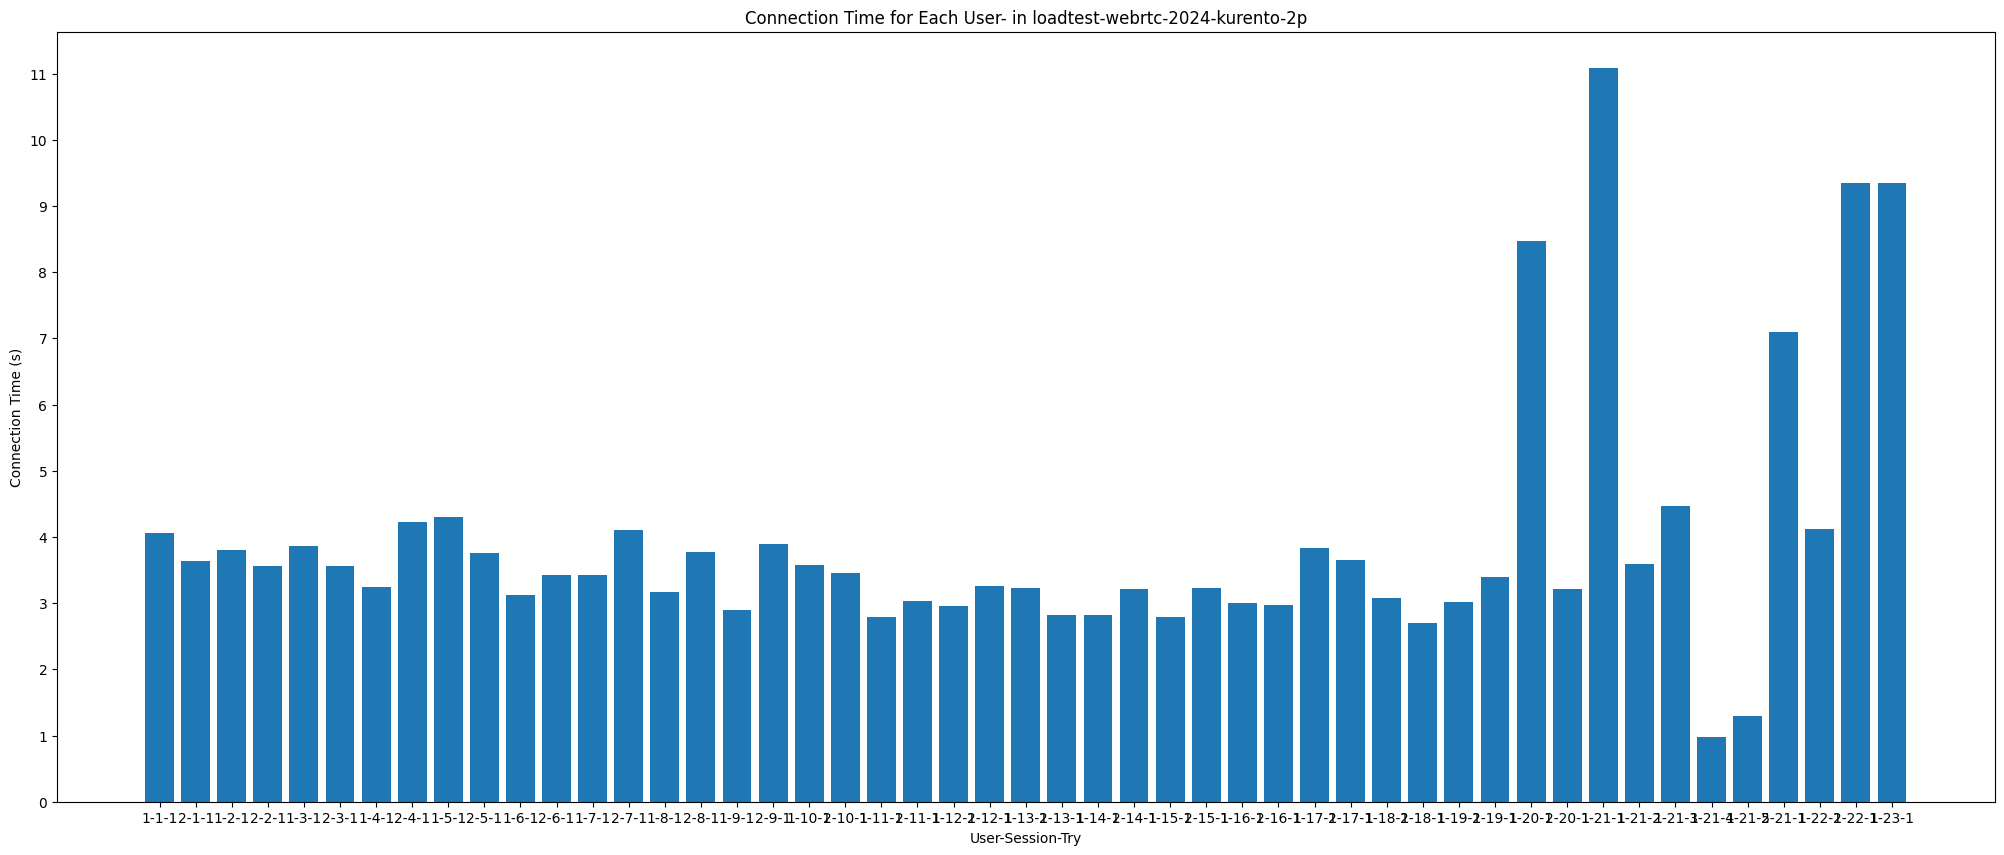

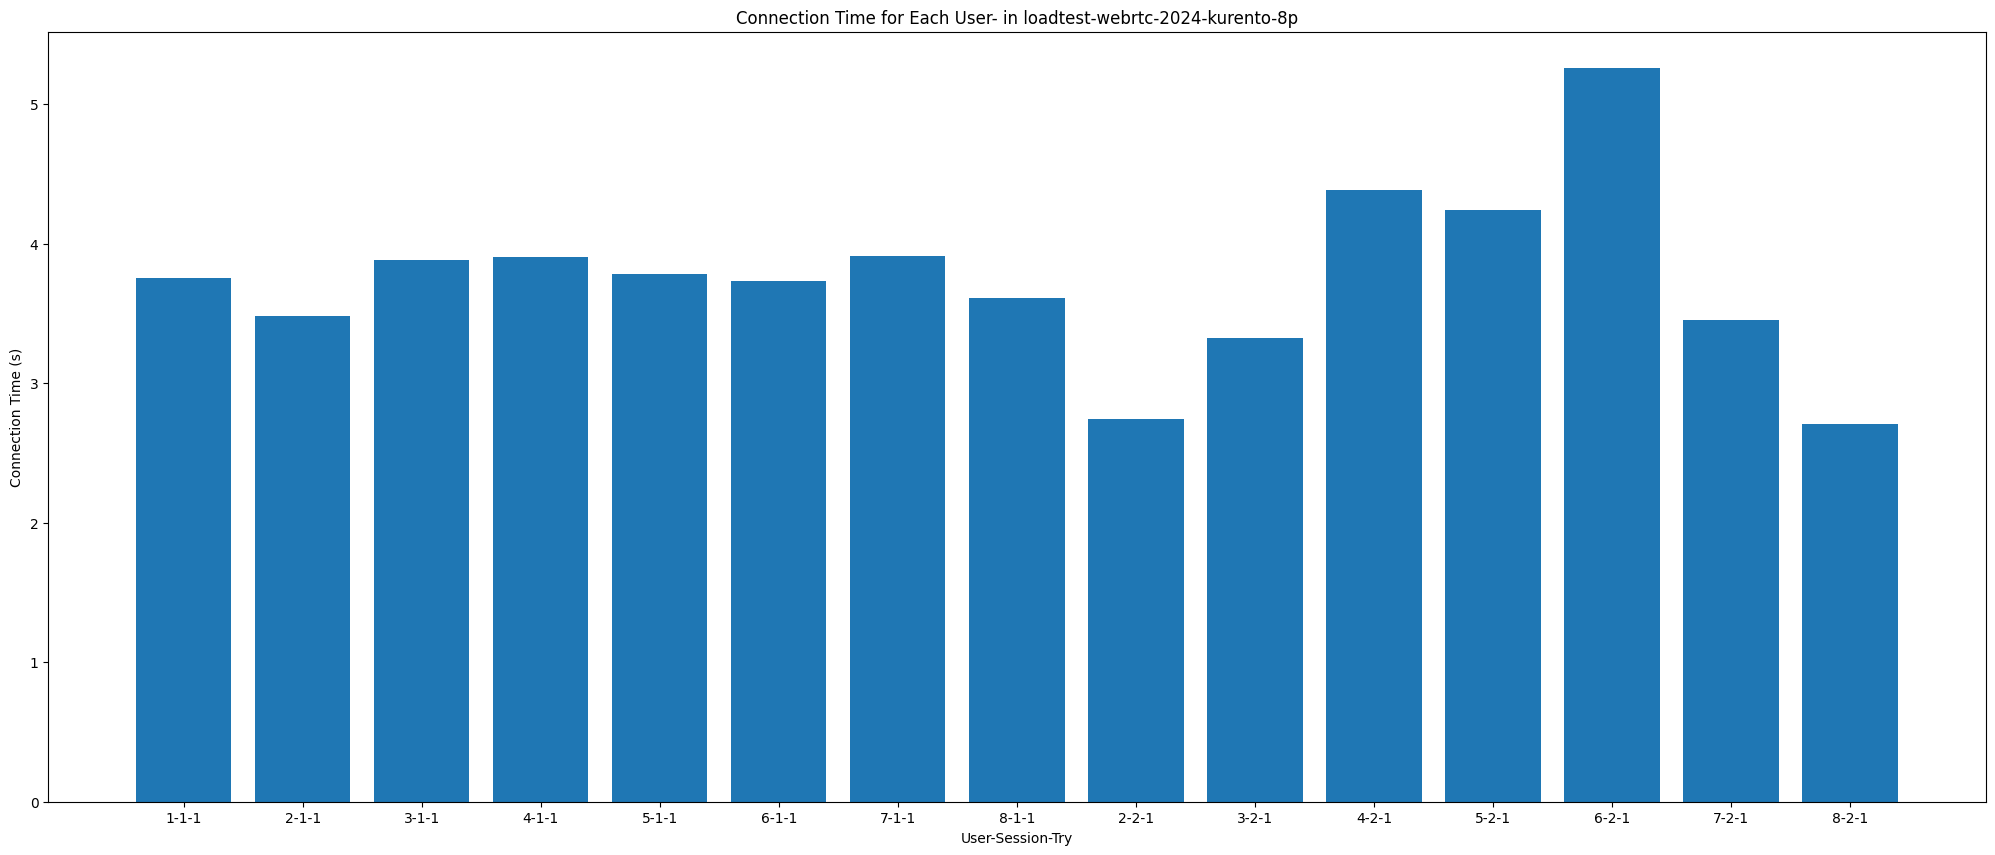

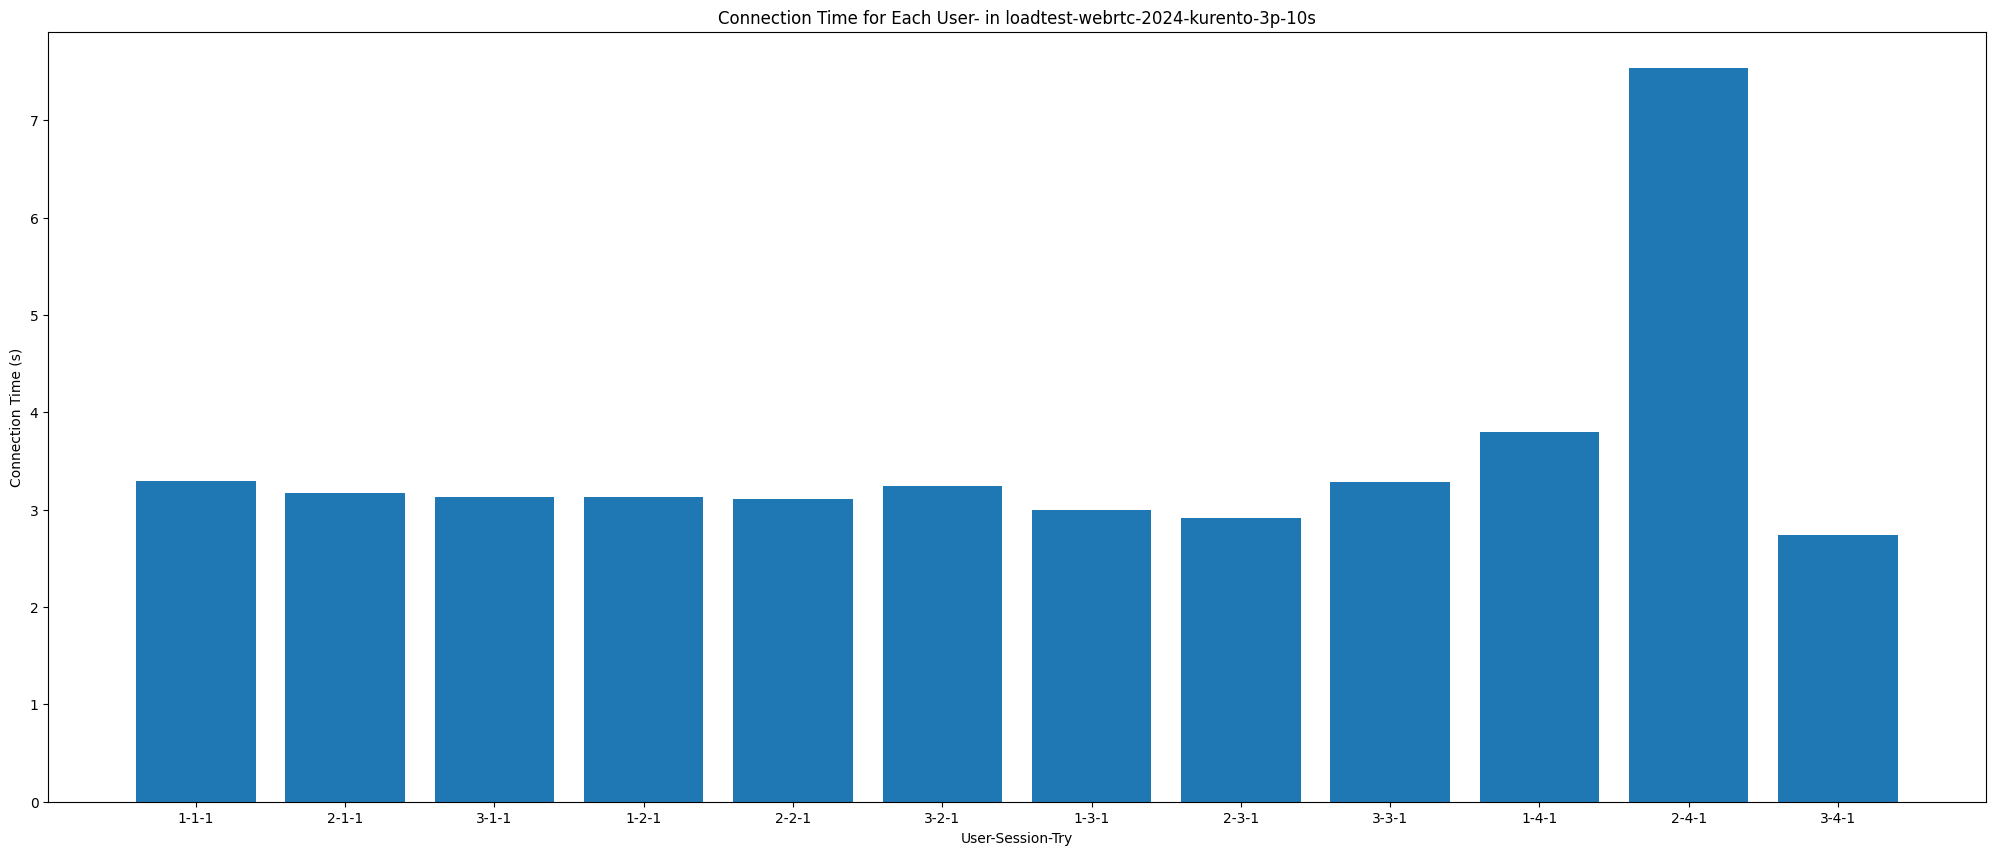

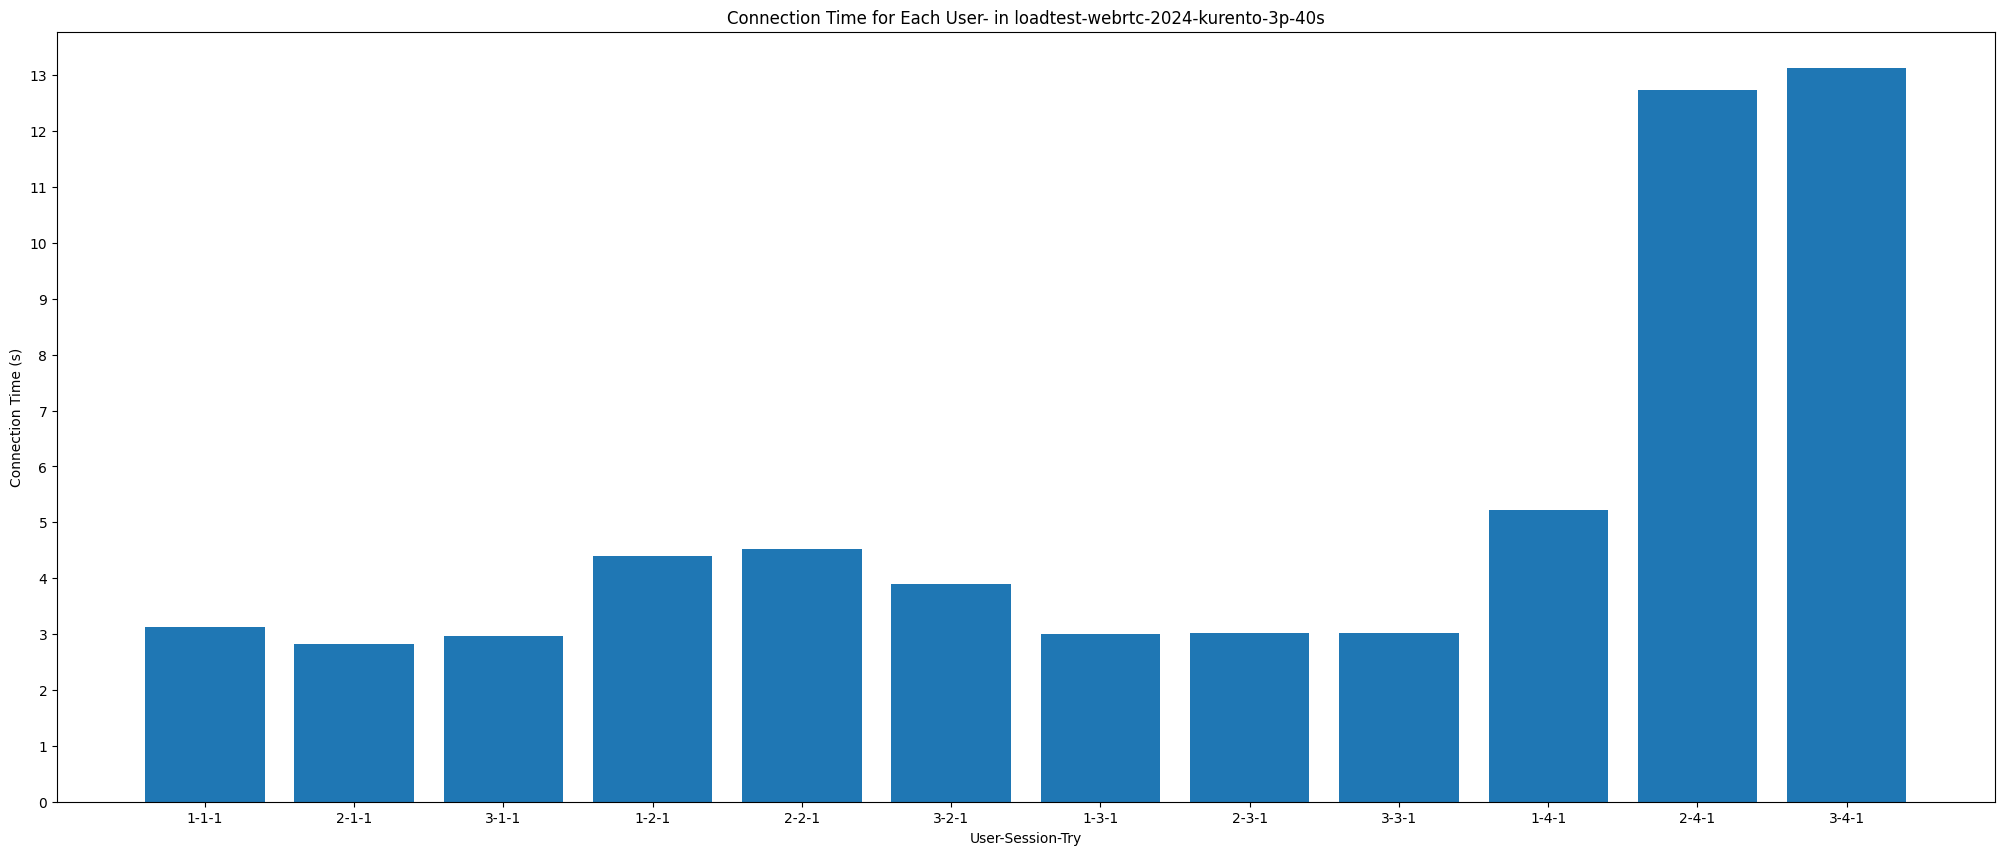

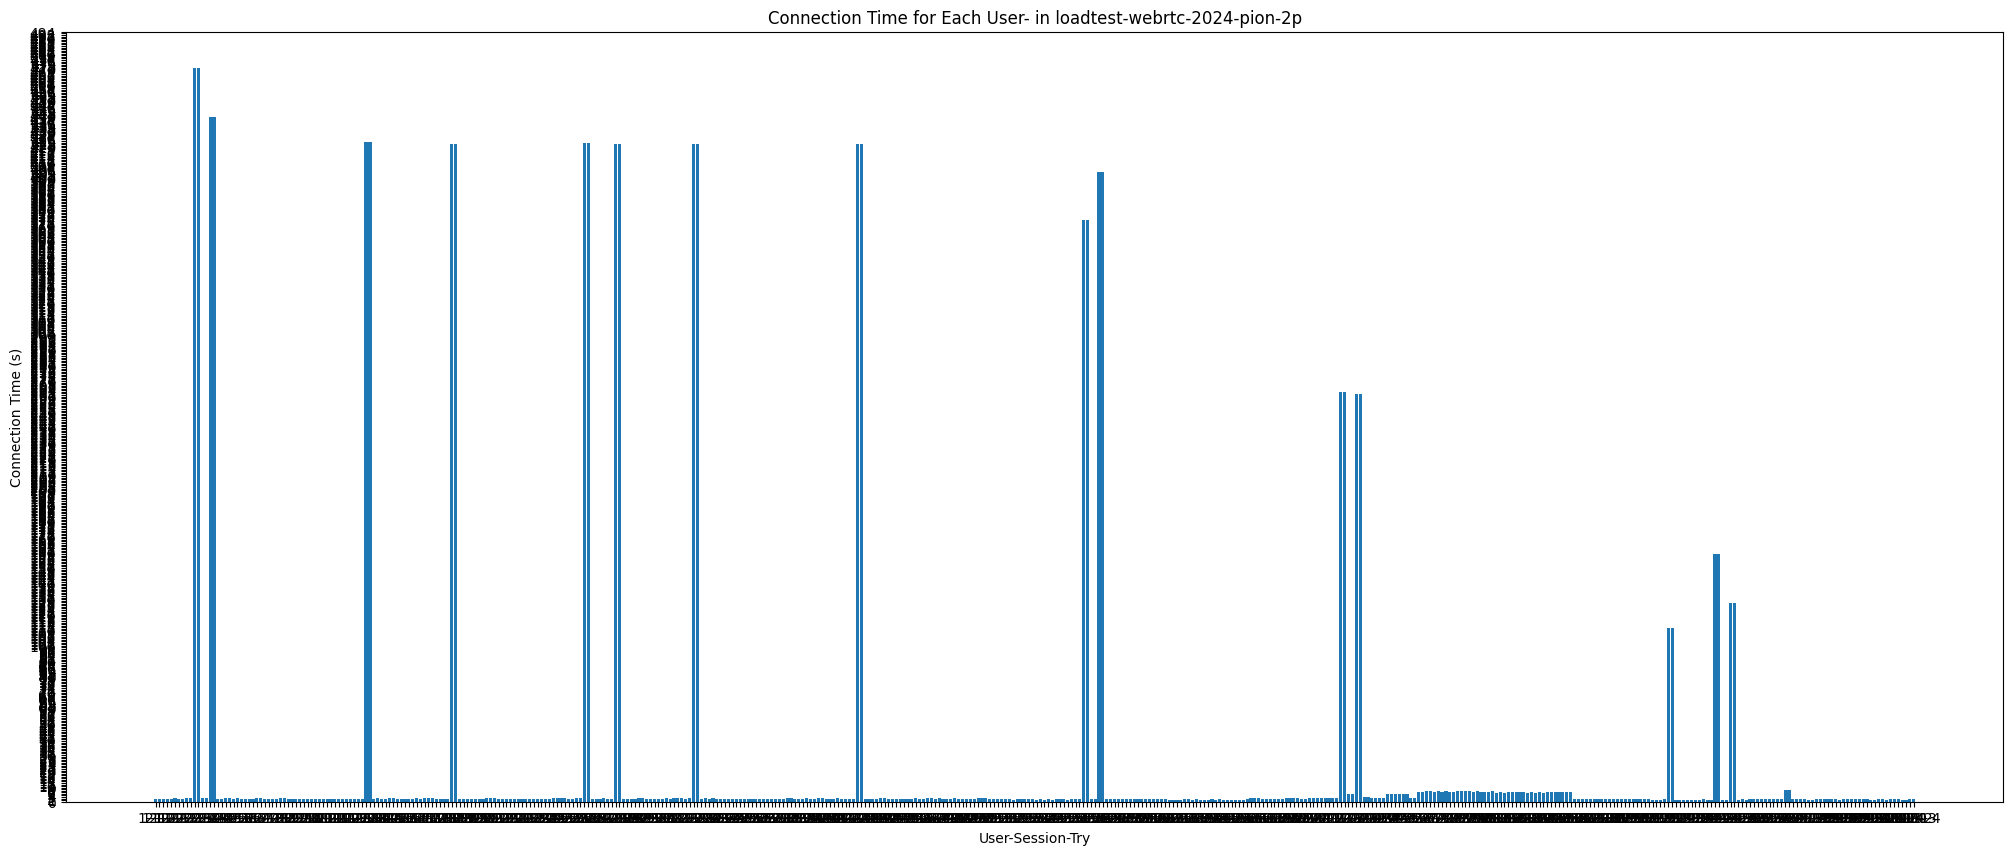

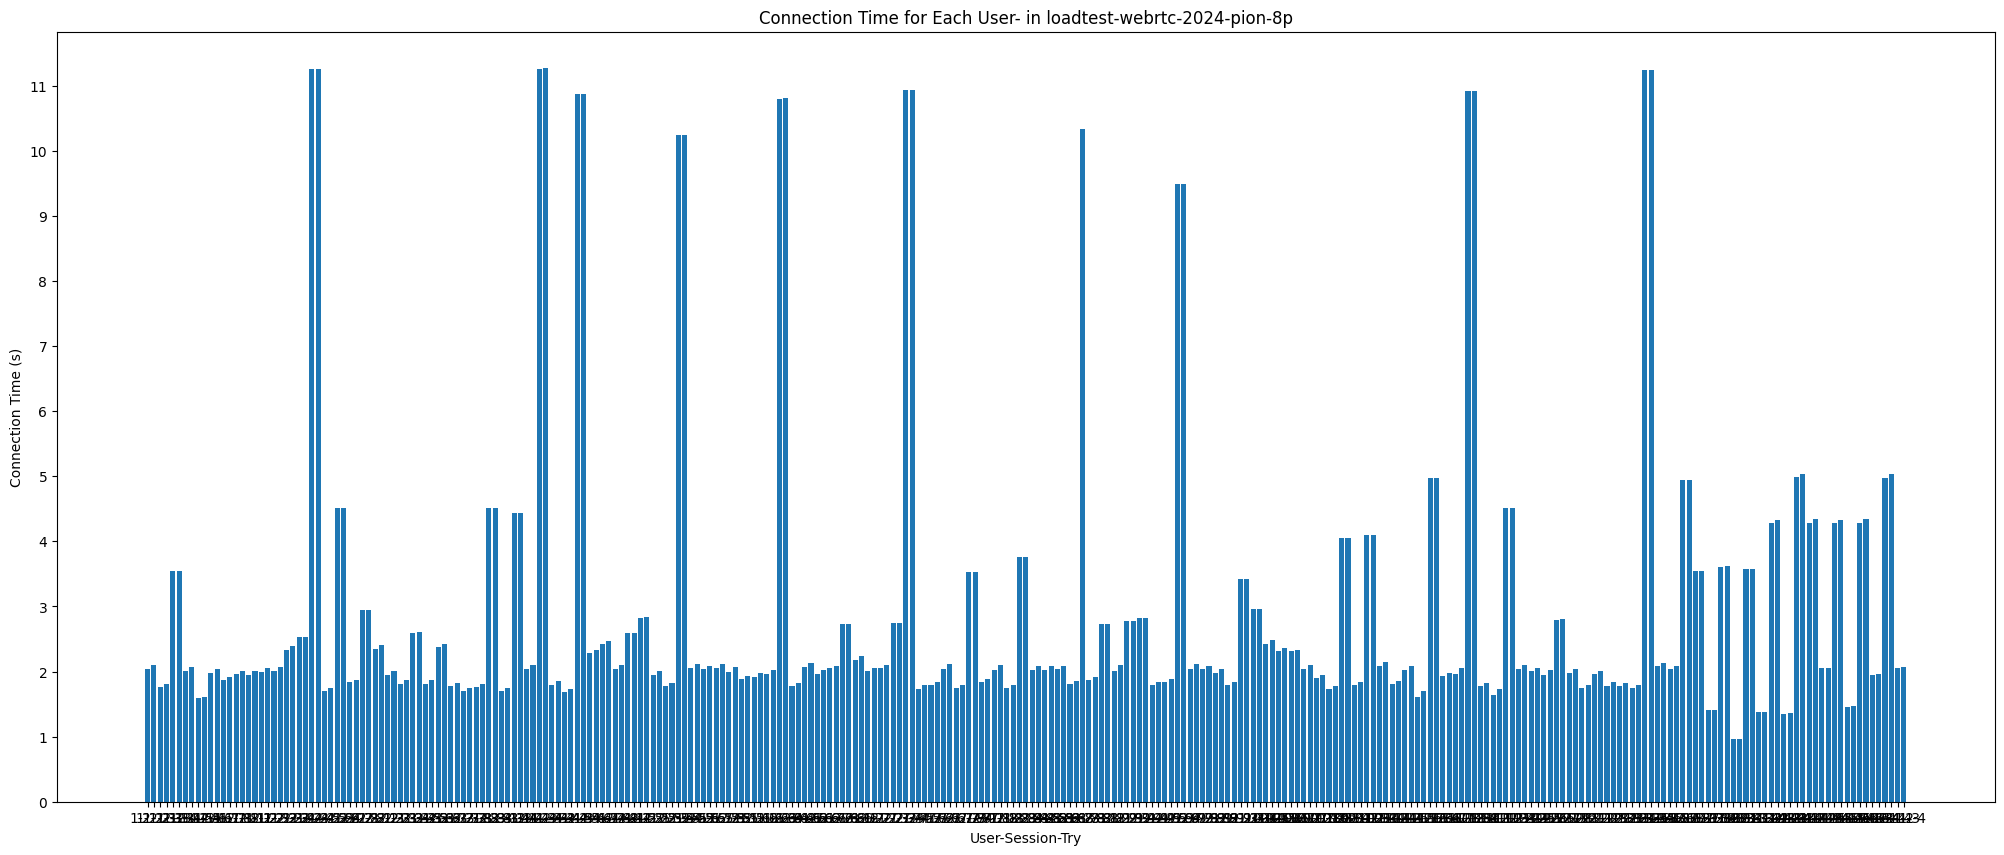

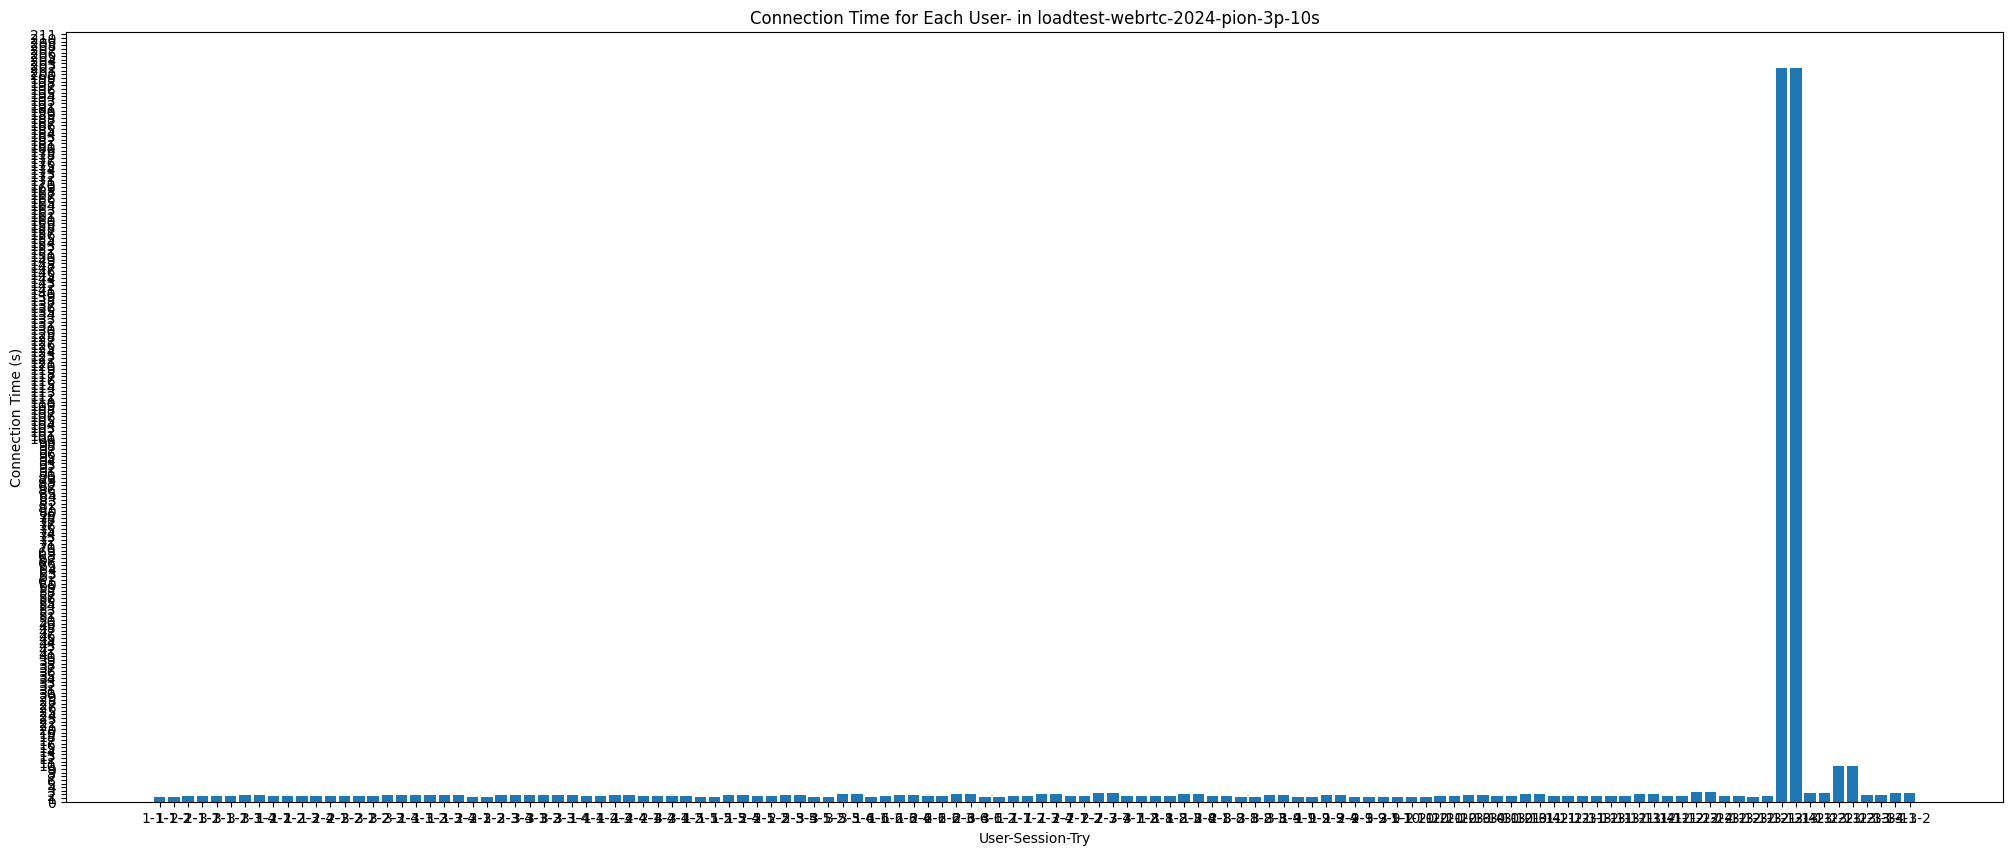

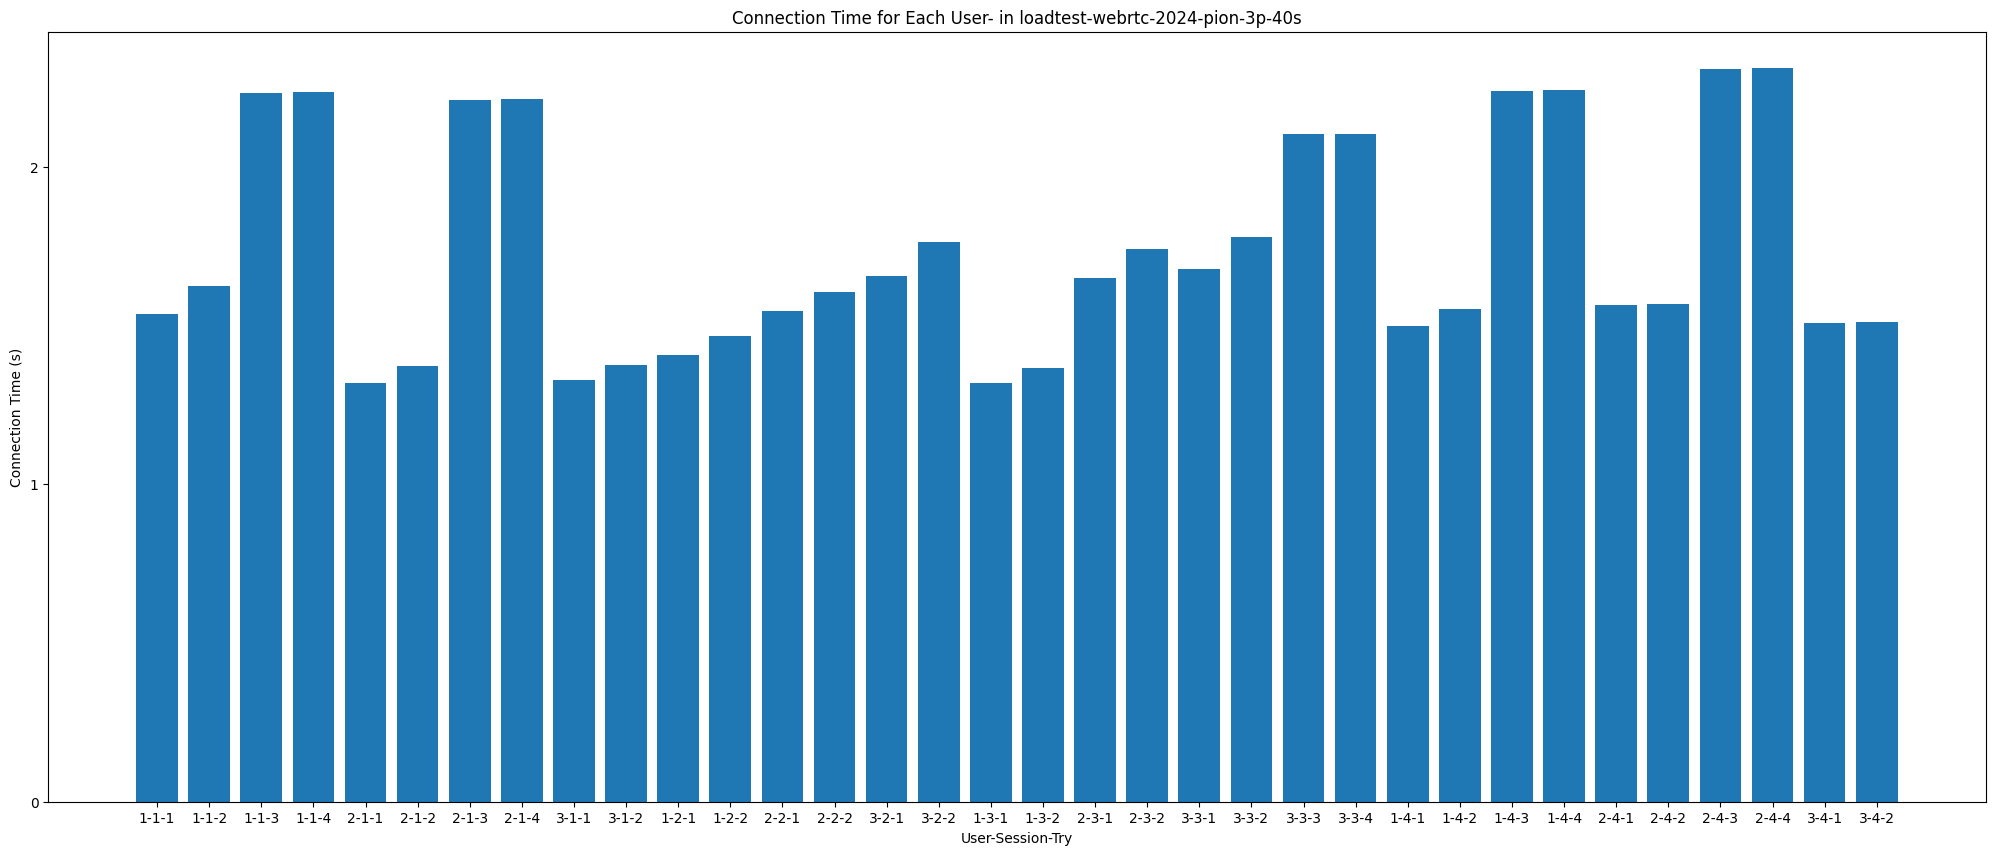

In [18]:
plt.rcParams["figure.figsize"] = [25, 10]
full_connection_times = {}
full_connection_times_max = {}
for index_list_name in index_list_names:
    events_df = events_dfs[index_list_name]
    connection_times = []
    connection_times_max = []
    # get all sessions in events_df
    sessions = events_df['session'].unique()
    # for each session, calculate streams in and out
    for session in sessions:
        # get all users in this session
        users = events_df[events_df['session'] == session]['user'].unique()
        for user in users:
            # get all events for this user in this session
            user_events = events_df[(events_df['session'] == session) & (events_df['user'] == user)]
            # get all 'event' 'connectionStart' events and all 'event' 'streamCreated' with 'connection' 'local'
            connection_starts = user_events[user_events['event'] == 'connectionStart']
            if connection_starts.empty:
                connection_starts = user_events[user_events['event'] == 'signalConnected']
                if connection_starts.empty:
                    continue
            stream_created_locals = user_events[(user_events['event'] == 'streamCreated') & (user_events['connection'] == 'local')]
            full_user = str(user).replace("User", "") + "-" + str(session).replace("LoadTestSession", "")
            connection_start_min = connection_starts['timestamp'].min()
            stream_created_max = stream_created_locals['timestamp'].max()
            connection_times_max.append({
                'user': full_user,
                'connection_time': (stream_created_max - connection_start_min).total_seconds(),
            })
            prev_user = None
            tries = 1
            for i, stream_created_local in stream_created_locals.iterrows():
                # get the closest connectionStart event before the streamCreated event
                connection_start = connection_starts[connection_starts['timestamp'] < stream_created_local['timestamp']].iloc[-1]['timestamp']
                # calculate the time difference between the two
                connection_time = stream_created_local["timestamp"] - connection_start
                if full_user == prev_user:
                    tries += 1
                else:
                    tries = 1
                prev_user = full_user
                connection_times.append({
                    'user': full_user + "-" + str(tries),
                    'connection_time': connection_time.total_seconds()
                })
    connection_times = pd.DataFrame(connection_times)
    # connection_times["user"] has strings with format 'X-Y' where X is the user number and Y is the session number
    # sort it by Y first, then X
    # Step 1: Split the 'X-Y' strings into two columns
    connection_times[['user_num', 'session', 'try']] = connection_times['user'].str.split('-', expand=True)

    # Step 2: Convert the new columns to integers
    connection_times['user_num'] = connection_times['user_num'].astype(int)
    connection_times['session'] = connection_times['session'].astype(int)
    connection_times['try'] = connection_times['try'].astype(int)
    connection_times = connection_times.sort_values(by=['session', 'user_num', 'try']).reset_index(drop=True)

    connection_times_max = pd.DataFrame(connection_times_max)
    connection_times_max[['user_num', 'session']] = connection_times_max['user'].str.split('-', expand=True)

    connection_times_max['user_num'] = connection_times_max['user_num'].astype(int)
    connection_times_max['session'] = connection_times_max['session'].astype(int)
    connection_times_max = connection_times_max.sort_values(by=['session', 'user_num']).reset_index(drop=True)

    # bar chart of connection times

    # # bar chart of connection times
    # connection_times_df = pd.DataFrame(connection_times, columns=['connection_time'])
    # connection_times_df['connection_time'] = connection_times_df['connection_time'].dt.total_seconds()
    # connection_times_df['user'] = users_in
    # connection_times_df = connection_times_df.sort_values(by='connection_time')
    fig, ax = plt.subplots()
    ax.bar(connection_times['user'], connection_times['connection_time'])
    ax.set_xlabel('User-Session-Try')
    ax.set_ylabel('Connection Time (s)')
    ax.set_title(f'Connection Time for Each User- in {index_list_name}')
    # y ticker 1
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    #plt.xticks(rotation=45)
    #display(connection_times_max)

# red color for retries, green for first try
# stacked bar for each state (connectionStart, streamCreated, streamDestroyed)
# check if exception is in event before streamDestroyed
# reconnect times?
# histogram of reconnections (y axis n reconnects)

In [200]:
# each element in the webrtcStats column is a JSON array of JSONs
# for each JSON, there is a webrtcStats property that is a JSON array of JSONs
# for each JSON, there is an event property that is a string
# we want to count the number of times each event type occurs

def extract_events(row):
    events = []
    webrtc_stats_list = row['webrtcStats']
    for item in webrtc_stats_list:
        if 'event' in item:
            events.append(item['event'])
    return events

stats = user_data[0]['stats']
# Apply the function to each row and collect all events
all_events = []
for index, row in enumerate(stats):
    all_events.extend(extract_events(row))

# Count the occurrences of each event
event_counts = Counter(all_events)

# Convert the Counter to a DataFrame for better visualization
event_counts_df = pd.DataFrame(event_counts.items(), columns=['event', 'count'])

display(event_counts_df)

,event,count
0,getUserMedia,4
1,addConnection,8
2,onnegotiationneeded,1
3,onsignalingstatechange,2
4,onicegatheringstatechange,2
5,onicecandidate,51
6,oniceconnectionstatechange,2
7,onconnectionstatechange,2
8,stats,1044


In [201]:
stats_events = []
for index, row in enumerate(stats):
    webrtc_stats_list = row['webrtcStats']
    for item in webrtc_stats_list:
        if 'event' in item:
            if item['event'] == 'stats':
                stats_events.append(item)

df = pd.DataFrame(stats_events)
display(df.head())


,event,tag,peerId,connectionId,timeTaken,data,timestamp
0,stats,stats,User1,d9f63f67-9826-413a-becc-01a99b8f6116,2,"{'audio': {'inbound': [], 'outbound': []}, 'vi...",2024-05-29T12:11:37.024Z
1,stats,stats,User1,d9f63f67-9826-413a-becc-01a99b8f6116,3,"{'audio': {'inbound': [], 'outbound': [{'id': ...",2024-05-29T12:11:38.026Z
2,stats,stats,User1,d9f63f67-9826-413a-becc-01a99b8f6116,1,"{'audio': {'inbound': [], 'outbound': [{'id': ...",2024-05-29T12:11:39.027Z
3,stats,stats,User6,str_CAM_D4Fm_con_PyYwkbEWPY,1,"{'audio': {'inbound': [{'id': 'c286fa59', 'tim...",2024-05-29T12:11:39.027Z
4,stats,stats,User2,str_CAM_VExG_con_KpGc40Dh39,2,"{'audio': {'inbound': [{'id': '1b644261', 'tim...",2024-05-29T12:11:39.027Z


In [202]:
df["data"]
normalized_qos = pd.json_normalize(df["data"])
# add df["peerId"] to normalized_qos
normalized_qos["peerId"] = df["peerId"]
display(normalized_qos.head())

,audio.inbound,audio.outbound,video.inbound,video.outbound,connection.id,connection.timestamp,connection.type,connection.bytesReceived,connection.bytesSent,connection.lastPacketReceivedTimestamp,...,connection.remote.address,connection.remote.candidateType,connection.remote.port,connection.remote.priority,connection.remote.protocol,remote.audio.inbound,remote.audio.outbound,remote.video.inbound,remote.video.outbound,peerId
0,[],[],[],[],b7ffb90a,1716984697019,candidate-pair,1581,781,1716984696998,...,3.235.188.0,srflx,51095,1679819263,udp,[],[],[],[],User1
1,[],"[{'id': '4add456', 'timestamp': 1716984698023,...",[],[],b7ffb90a,1716984698021,candidate-pair,1581,1527,1716984696998,...,3.235.188.0,srflx,51095,1679819263,udp,[],[],[],[],User1
2,[],"[{'id': '4add456', 'timestamp': 1716984699022,...",[],"[{'id': '88b73cf5', 'timestamp': 1716984699022...",b7ffb90a,1716984699022,candidate-pair,2039,57778,1716984698654,...,3.235.188.0,srflx,51095,1679819263,udp,"[{'id': 'd6371651', 'timestamp': 1716984698653...",[],[],[],User1
3,"[{'id': 'c286fa59', 'timestamp': 1716984699023...",[],"[{'id': '8f0fc42c', 'timestamp': 1716984699023...",[],ce11eccf,1716984699023,candidate-pair,56318,846,1716984699020,...,3.235.188.0,srflx,43808,1679819007,udp,[],"[{'id': '9e8a6e3a', 'timestamp': 1716984698732...",[],"[{'id': '191e25c0', 'timestamp': 1716984699019...",User6
4,"[{'id': '1b644261', 'timestamp': 1716984699025...",[],"[{'id': '69e4a831', 'timestamp': 1716984699025...",[],a0fd833e,1716984699024,candidate-pair,40576,847,1716984699020,...,3.235.188.0,srflx,50396,1679819007,udp,[],"[{'id': 'b274c4a5', 'timestamp': 1716984698732...",[],"[{'id': '92747476', 'timestamp': 1716984698918...",User2


In [203]:
#remove all entries where audio.inbound is an empty list
def not_empty_list(x):
    return x != []
normalized_inbound = normalized_qos[normalized_qos["audio.inbound"].apply(not_empty_list)]

# keep only audio.inbound, video.inbound, remote.audio.outbound, remote.video.outbound and peerID
normalized_inbound = normalized_inbound[["audio.inbound", "video.inbound", "remote.audio.outbound", "remote.video.outbound", "peerId"]]

def expand_column(df, column_name):
    expanded = df[column_name].apply(pd.Series).stack().reset_index(level=1, drop=True)
    expanded = pd.json_normalize(expanded)
    return expanded

audio_inbound = expand_column(normalized_inbound, "audio.inbound")
video_inbound = expand_column(normalized_inbound, "video.inbound")
remote_audio_outbound = expand_column(normalized_inbound, "remote.audio.outbound")
remote_video_outbound = expand_column(normalized_inbound, "remote.video.outbound")

In [204]:
df_cpu_list = []
index_kurento_names = [
    "loadtest-webrtc-2024-kurento-8p"
]

index_list_names = index_kurento_names

for index in index_list_names:
    df_cpu = pd.read_csv(f"dfs_final/{index}-medianode.csv")
    df_cpu["@timestamp"] = pd.to_datetime(df_cpu["@timestamp"])
    df_cpu_list.append(df_cpu)

In [205]:
plt_audio_inbound = audio_inbound.loc[:, ["timestamp", "packetRate", "bitrate"]]
plt_audio_inbound["timestamp"] = pd.to_datetime(plt_audio_inbound["timestamp"], unit="ms")

cpu = df_cpu_list[0]
cpu = cpu.drop(columns=["memory"]).dropna()
cpu["@timestamp"] = pd.to_datetime(cpu["@timestamp"], format="ISO8601").dt.tz_localize(None)

publishers_progression["timestamp"] = publishers_progression["timestamp"].dt.tz_localize(None)

# here min_ts is calculated as the minimum datetime of the 3 dataframes
# cpu are time aware while plt_audio_inbound is not
min_ts = pd.concat([cpu["@timestamp"], publishers_progression["timestamp"], plt_audio_inbound["timestamp"]]).min()

cpu_td = pd.DataFrame(columns=["timestamp", "cpu"])

cpu_td["timestamp"] = (cpu["@timestamp"] - min_ts).dt.total_seconds()
cpu_td["cpu"] = cpu["cpu"]

user_td = pd.DataFrame(columns=["timestamp", "publishers"])
user_td["timestamp"] = (publishers_progression["timestamp"] - min_ts).dt.total_seconds()
user_td["publishers"] = publishers_progression["number"]
user_td["label"] = publishers_progression["user"] + "-" + publishers_progression["session"]

plt_audio_inbound["timestamp"] = (plt_audio_inbound["timestamp"] - min_ts).dt.total_seconds()

Text(0.5, 0.98, 'Users over time')

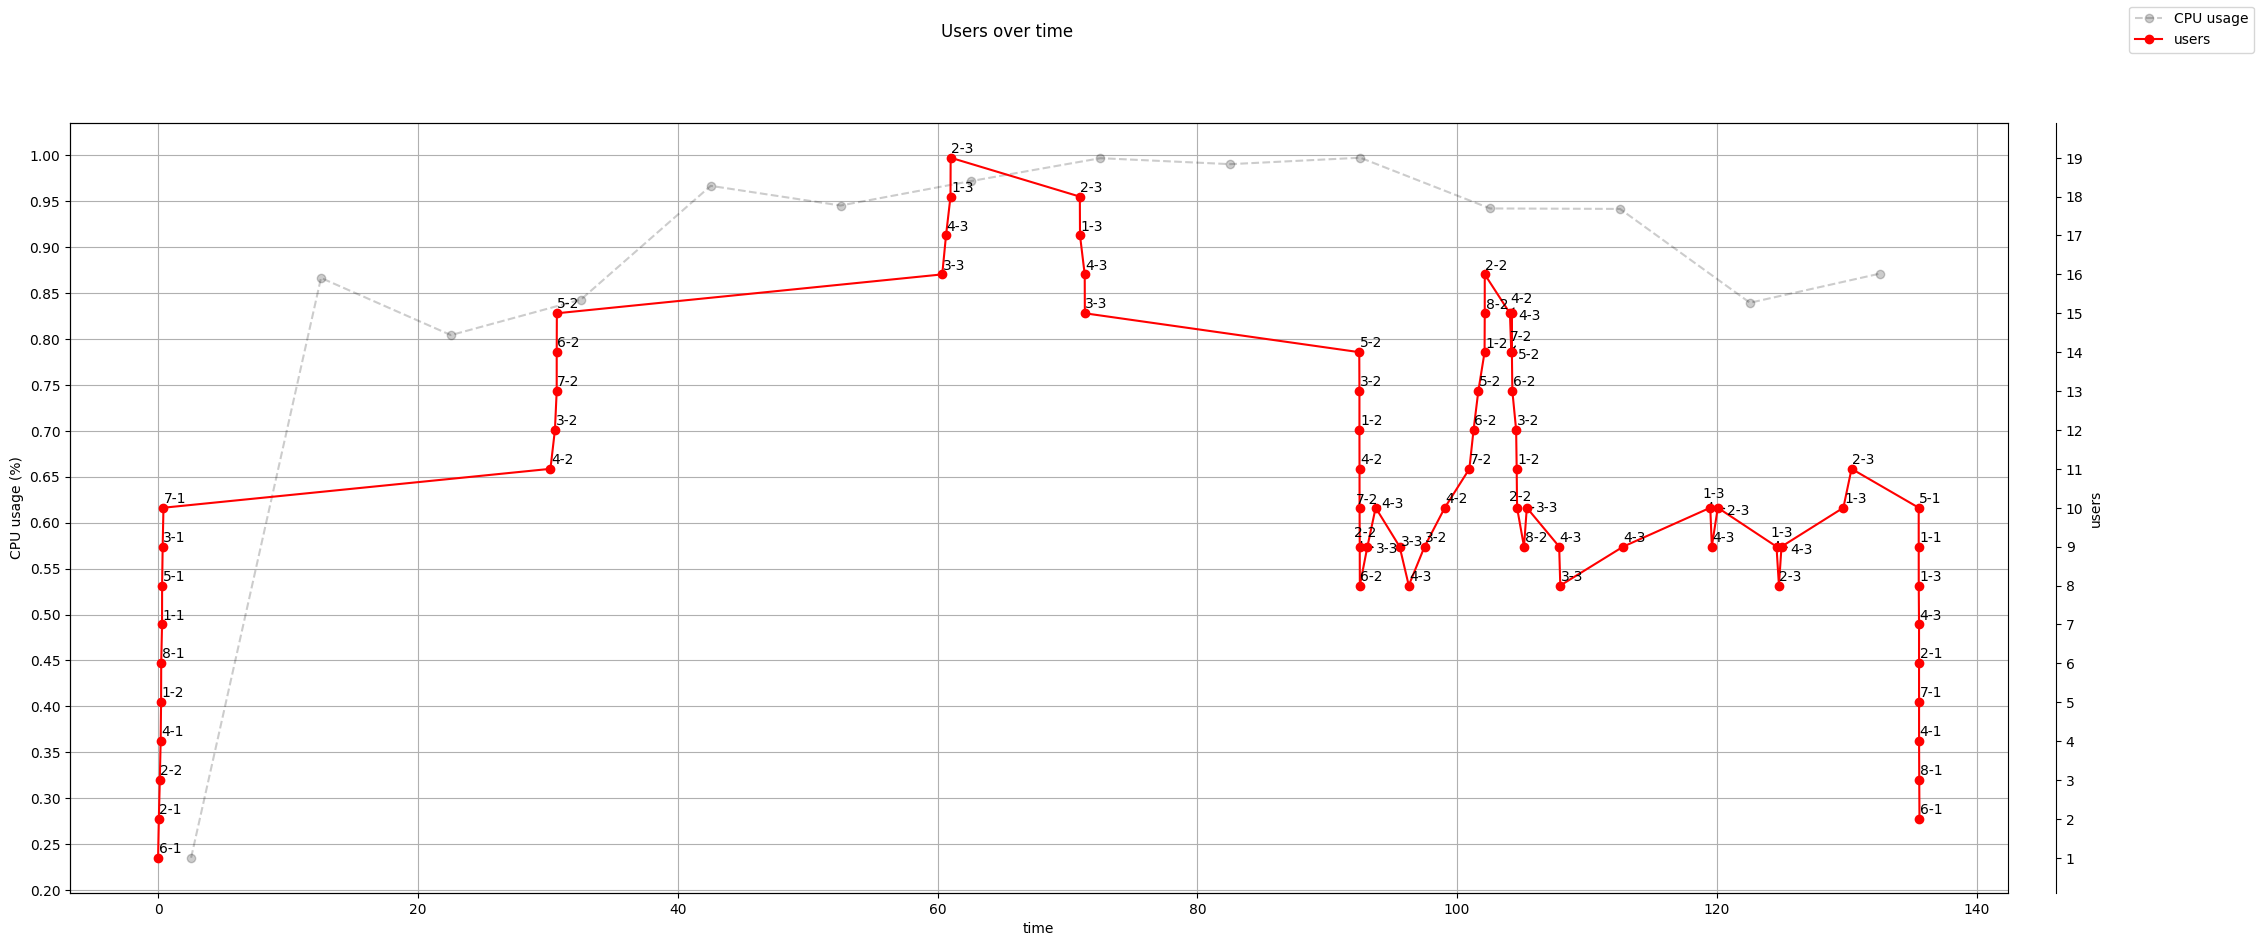

In [212]:
plt.rcParams["figure.figsize"] = [25, 10]

fig, ax = plt.subplots()
ax.plot(cpu_td["timestamp"], cpu_td["cpu"], label="CPU usage", color="black", marker="o", linestyle="--", alpha=0.2)
ax.set_xlabel("time")
ax.set_ylabel("CPU usage (%)")
ax.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
#ax.set_xlim(100, 110)
ax2 = ax.twinx()
ax2.set_ylabel("users")
ax2.spines["right"].set_position(("axes", 1.025))
ax2.plot(user_td["timestamp"], user_td["publishers"], label="users", color="red", marker="o", linestyle="-")
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))

# Annotate users plot with offset to prevent overlap
texts = [ax2.text(x, y, label) for x, y, label in zip(user_td["timestamp"], user_td["publishers"], user_td["label"])]
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='black'))

# Commented out third y-axis for bitrate
# ax3 = ax.twinx()
# ax3.set_ylabel("bitrate")
# ax3.spines["right"].set_position(("axes", 1.075))
# ax3.plot(plt_audio_inbound["timestamp"], plt_audio_inbound["bitrate"], label="bitrate", linestyle="-")

fig.legend(loc='upper right')
fig.suptitle("Users over time")

Text(0.5, 0.98, 'Inbound audio rate over time')

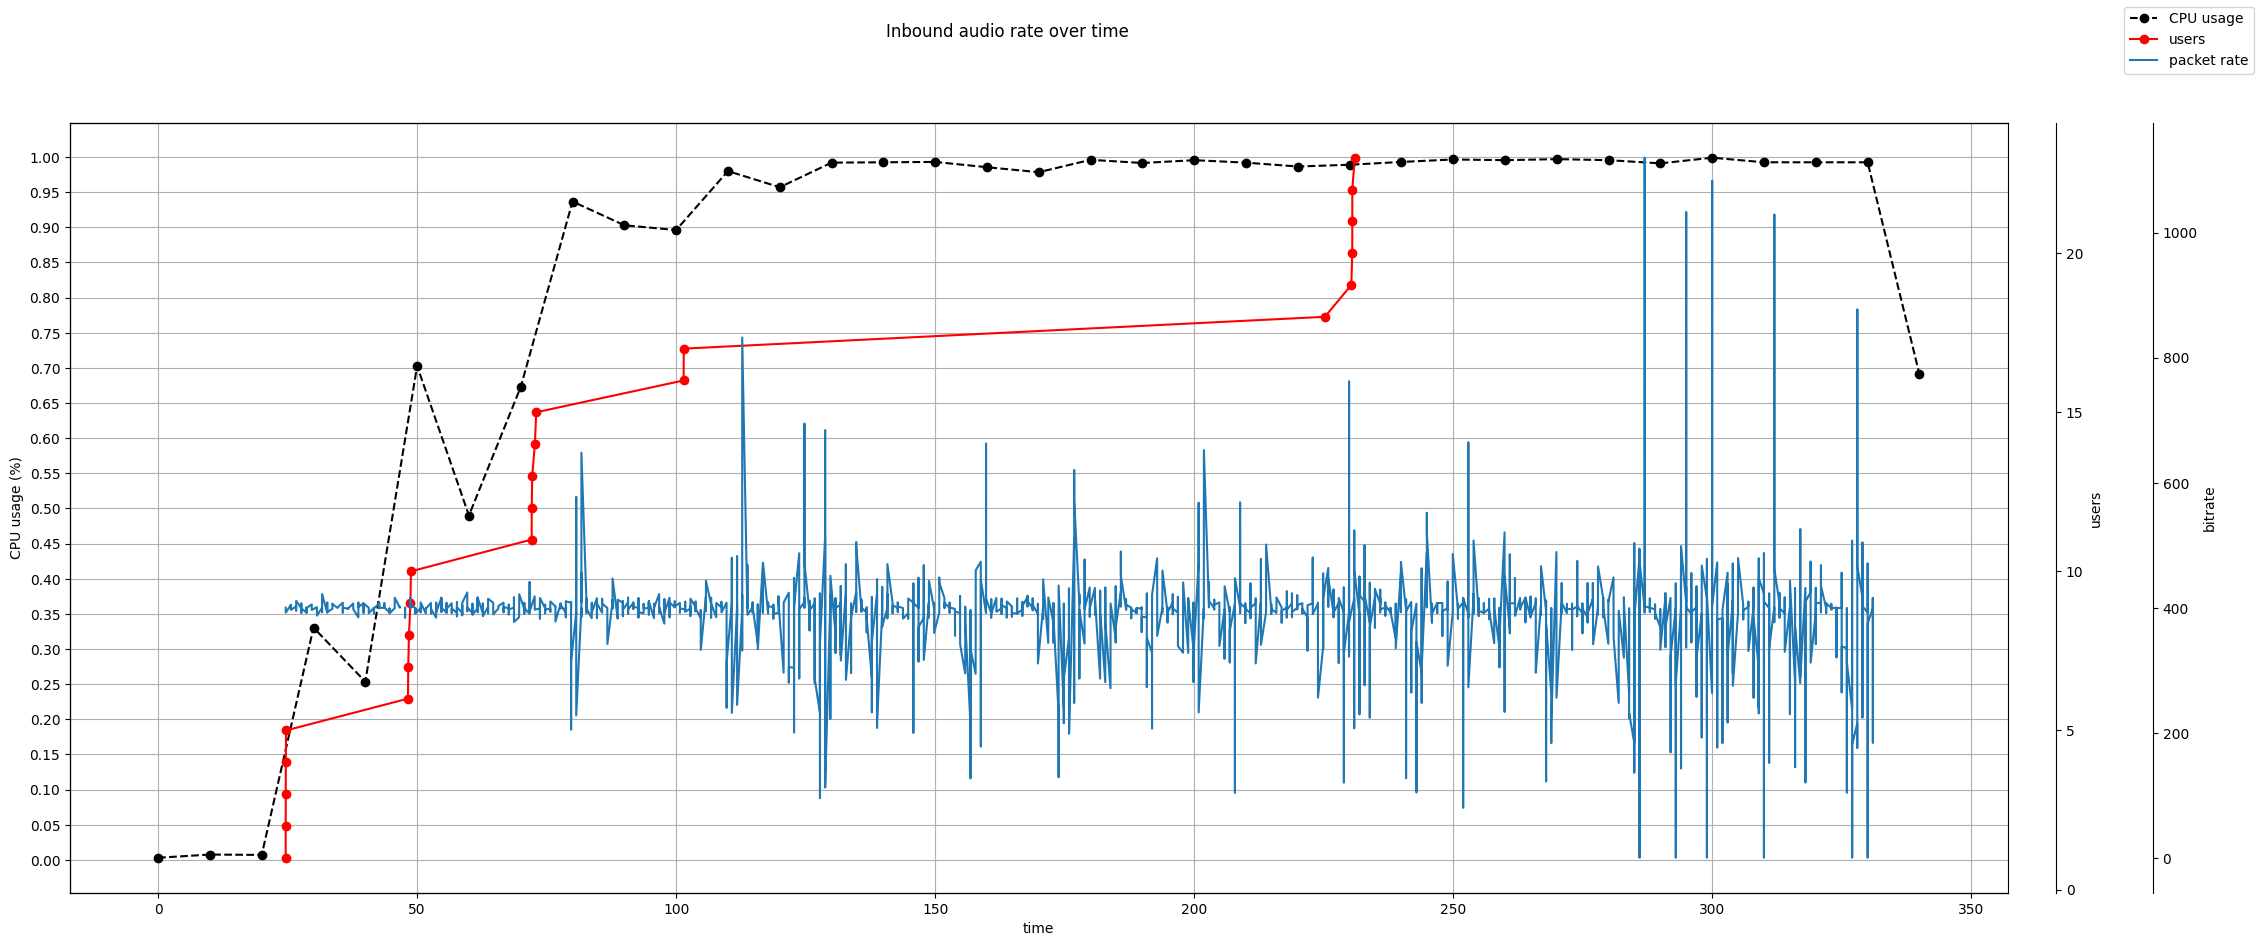

In [114]:
plt.rcParams["figure.figsize"] = [25, 10]

fig, ax = plt.subplots()
ax.plot(cpu_td["timestamp"], cpu_td["cpu"], label="CPU usage", color="black", marker="o", linestyle="--")
ax.set_xlabel("time")
ax.set_ylabel("CPU usage (%)")
ax.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax2 = ax.twinx()
ax2.set_ylabel("users")
ax2.spines["right"].set_position(("axes", 1.025))
ax2.plot(user_td["timestamp"], user_td["publishers"], label="users", color="red", marker="o", linestyle="-")
ax3 = ax.twinx()
ax3.set_ylabel("bitrate")
ax3.spines["right"].set_position(("axes", 1.075))
ax3.plot(plt_audio_inbound["timestamp"], plt_audio_inbound["packetRate"], label="packet rate", linestyle="-")

fig.legend()
fig.suptitle("Inbound audio rate over time")

In [115]:
#remove all entries where audio.inbound is an empty list
def not_empty_list(x):
    return x != []
normalized_outbound = normalized_qos[normalized_qos["audio.outbound"].apply(not_empty_list)]

# keep only audio.inbound, video.inbound, remote.audio.outbound, remote.video.outbound and peerID
normalized_outbound = normalized_outbound[["audio.outbound", "video.outbound", "remote.audio.inbound", "remote.video.inbound", "peerId"]]

def expand_column(df, column_name):
    expanded = df[column_name].apply(pd.Series).stack().reset_index(level=1, drop=True)
    expanded = pd.json_normalize(expanded)
    return expanded

audio_outbound = expand_column(normalized_outbound, "audio.outbound")
video_outbound = expand_column(normalized_outbound, "video.outbound")
remote_audio_inbound = expand_column(normalized_outbound, "remote.audio.inbound")
remote_video_inbound = expand_column(normalized_outbound, "remote.video.inbound")

In [116]:
plt_remote_audio_inbound = remote_audio_inbound.loc[:, ["timestamp", "roundTripTime"]]
plt_remote_audio_inbound["timestamp"] = pd.to_datetime(plt_remote_audio_inbound["timestamp"], unit="ms")

min_ts = pd.concat([cpu["@timestamp"], user_join["@timestamp"], plt_remote_audio_inbound["timestamp"]]).min()

cpu_td["timestamp"] = (cpu["@timestamp"] - min_ts).dt.total_seconds()

user_td["timestamp"] = (user_join["@timestamp"] - min_ts).dt.total_seconds()

plt_remote_audio_inbound["timestamp"] = (plt_remote_audio_inbound["timestamp"] - min_ts).dt.total_seconds()

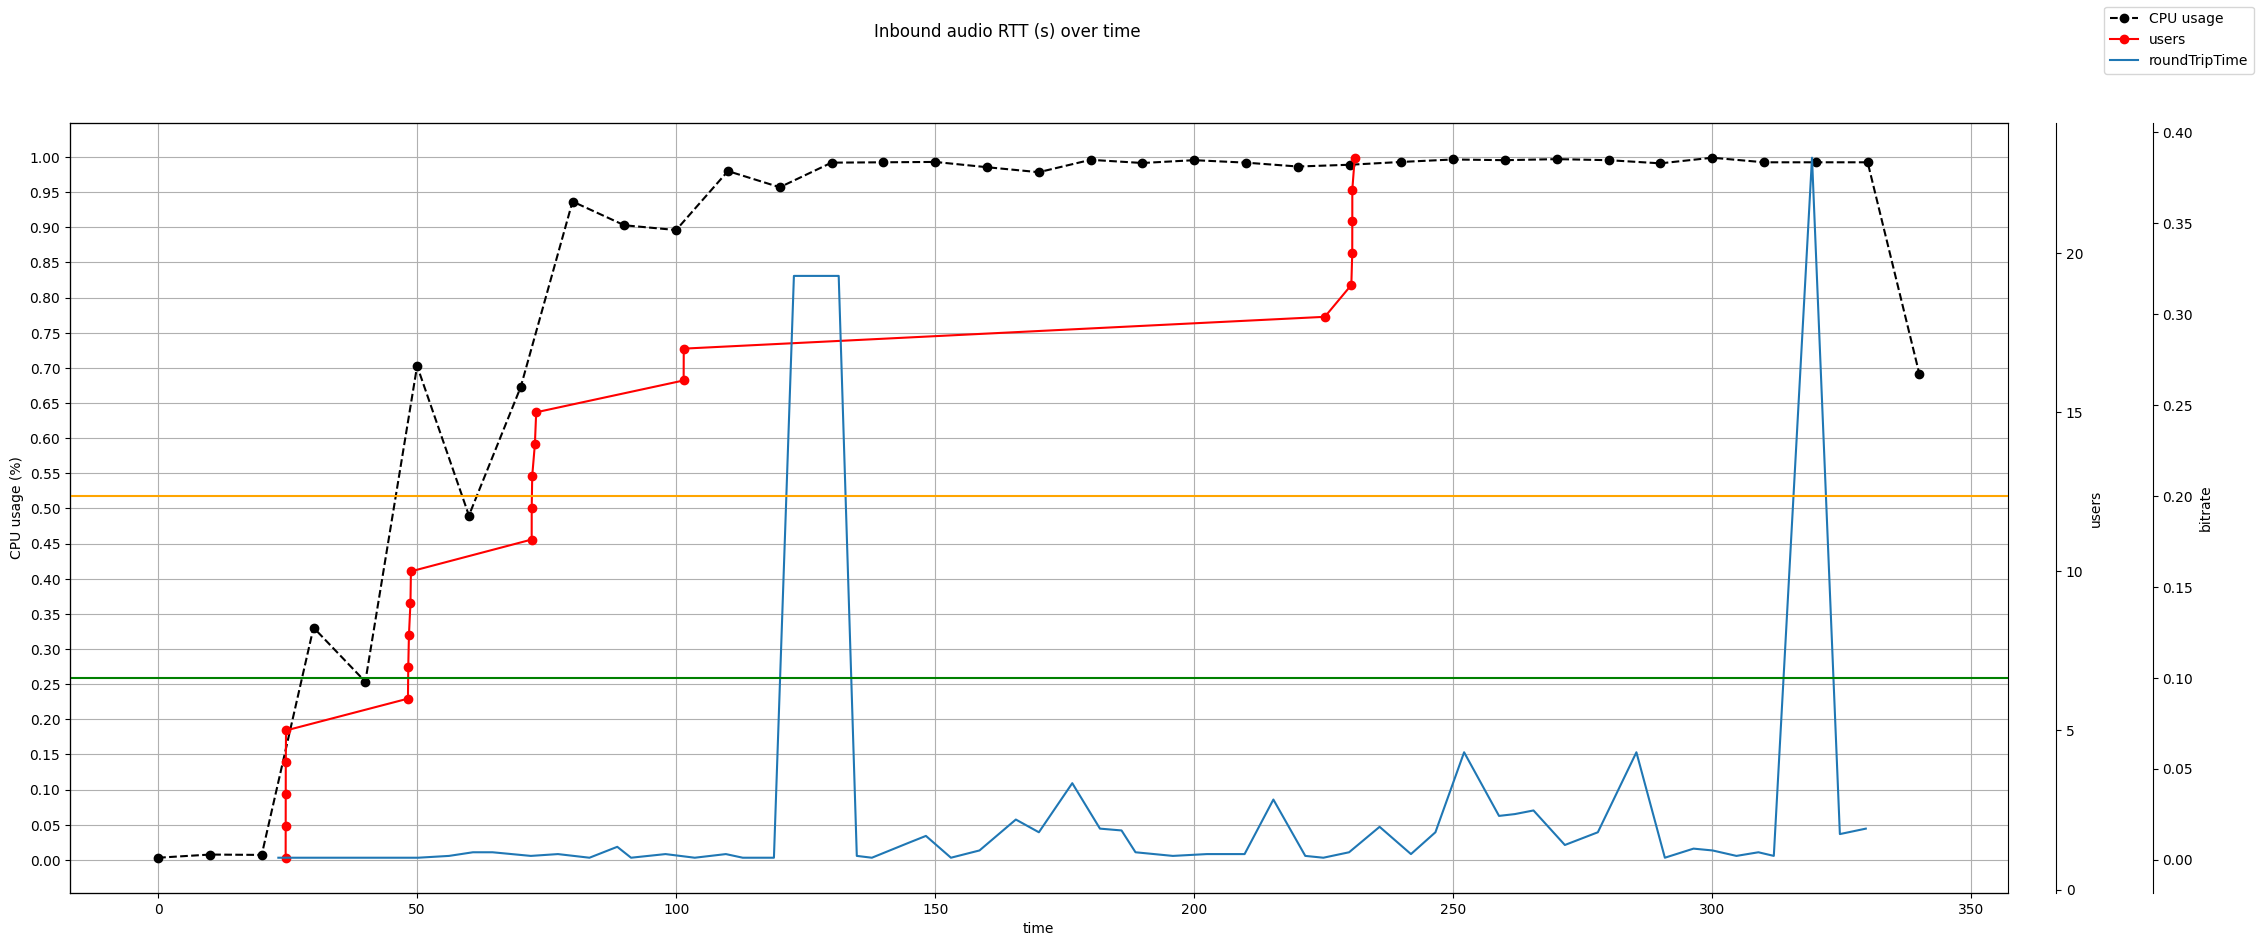

In [117]:
plt.rcParams["figure.figsize"] = [25, 10]

fig, ax = plt.subplots()
ax.plot(cpu_td["timestamp"], cpu_td["cpu"], label="CPU usage", color="black", marker="o", linestyle="--")
ax.set_xlabel("time")
ax.set_ylabel("CPU usage (%)")
ax.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax2 = ax.twinx()
ax2.set_ylabel("users")
ax2.spines["right"].set_position(("axes", 1.025))
ax2.plot(user_td["timestamp"], user_td["publishers"], label="users", color="red", marker="o", linestyle="-")
ax3 = ax.twinx()
ax3.set_ylabel("bitrate")
ax3.spines["right"].set_position(("axes", 1.075))
ax3.plot(plt_remote_audio_inbound["timestamp"], plt_remote_audio_inbound["roundTripTime"], label="roundTripTime", linestyle="-")

fig.legend()
fig.suptitle("Inbound audio RTT (s) over time")

ax3.axhline(y=0.1, color="green", linestyle="-", label="good rtt")
ax3.axhline(y=0.2, color="orange", linestyle="-", label="mediocre rtt")

In [118]:
# list of directories in stats/
dirs = os.listdir("stats/")
# read all events.json in each subdir
events = []
for i, dir in enumerate(dirs):
    subdirs = os.listdir(f"stats/{dir}")
    for subdir in subdirs:
        with open(f"stats/{dir}/{subdir}/events.json") as f:
            events.extend(json.load(f))

No stream created for connection User5-LoadTestSession3
No stream created for connection User6-LoadTestSession3
No stream created for connection User7-LoadTestSession3
No stream created for connection User8-LoadTestSession3


Text(0.5, 0.98, 'Time to publish for each connection (s)')

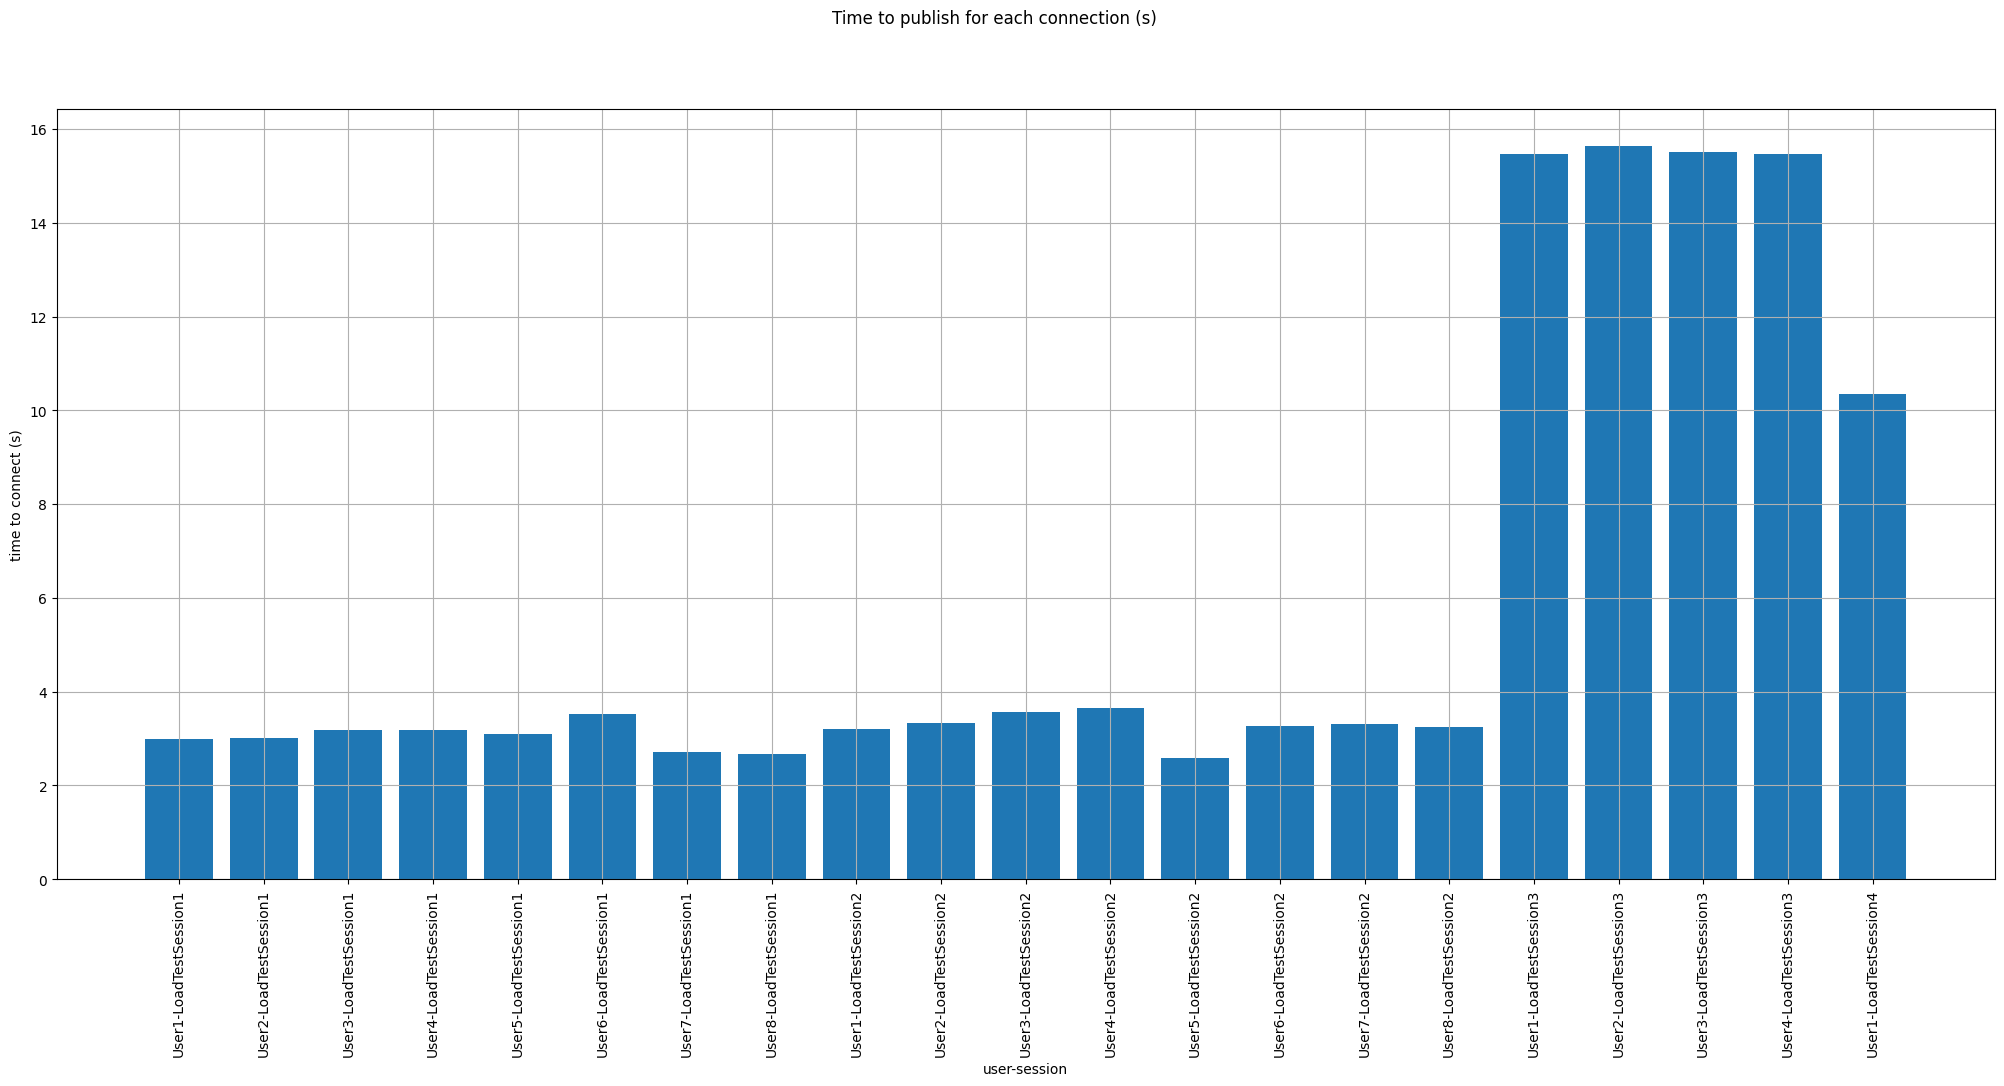

In [119]:
connection_start_fn = lambda x: (x['event'] == 'connectionStart')
connection = list(filter(connection_start_fn, events))

connection_df = pd.DataFrame(columns=["user", "session", "time to connect (s)", "connection start time", "stream created time"])
for i, conn in enumerate(connection):
    participant = conn['participant']
    session = conn['session']
    connection_start = conn['timestamp']
    stream_created = list(filter(lambda x: (x['event'] == 'streamCreated') and (x['connection'] == 'local') and (x['participant'] == participant) and (x['session'] == session), events))
    if len(stream_created) > 1:
        print(f"More than one stream created for connection {participant}-{session}")
    if len(stream_created) == 0:
        print(f"No stream created for connection {participant}-{session}")
        continue
    created_time = stream_created[0]['timestamp']
    # convert to datetime
    connection_start = datetime.strptime(connection_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    created_time = datetime.strptime(created_time, '%Y-%m-%dT%H:%M:%S.%fZ')
    time_diff = (created_time - connection_start).total_seconds()
    connection_df.loc[i] = [participant, session, time_diff, connection_start, created_time]

#display(connection_df)

#bar chart of time to connect
plt.rcParams["figure.figsize"] = [25, 10]
fig, ax = plt.subplots()
ax.bar(connection_df["user"] + "-"+ connection_df["session"], connection_df["time to connect (s)"])
ax.set_xlabel("user-session")
ax.set_ylabel("time to connect (s)")
# rotate x labels
plt.xticks(rotation=90)

ax.grid()
fig.suptitle("Time to publish for each connection (s)")